In [1]:
import csv
import time
import warnings
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, LeaveOneOut, cross_val_score, cross_val_predict
from sklearn.metrics import  r2_score
from category_encoders import LeaveOneOutEncoder

## Loading functions

In [2]:
# Importing function modules
%run general_functions.ipynb # read the data, preprocess etc.
%run plotting_functions.ipynb # contain all the plots
%run spatial_feature_functions.ipynb # functions to include the spatial information

## Spatial functions settings 


In [3]:
# Variables indicating whether to load the respective function
variables = {
    'GC': False, # Geographic coordinates
    'PGC': False, # Polynomial Geographic coordinates
    'OGC': False, # Oblique Geographic coordinates
    'WTC': False, # Wendand Transformed Coordinates
    'EDF': True, # Euclidean Distance Fields
    'EDM': False, # Euclidean Distance Matrix
    'PCA': False, # Principle Component Analysis
    'ESF': False, # Eigenvector Spatial Filtering
}

# Parameters for the functions
parameters = {
    'OGC': (0, 3, 181),# start, step, stop NO3:(0, 6, 181)
    'WTC': int(12), #18=6084, 12=2541
    'EDF': (False), #If True edf will be normalized
    'EDM': (True),
    'PCA': int(28), #NO§:27, Zinc: 1
    'ESF': (48, 17), # search distance, eigenvalues
}

save_results = False

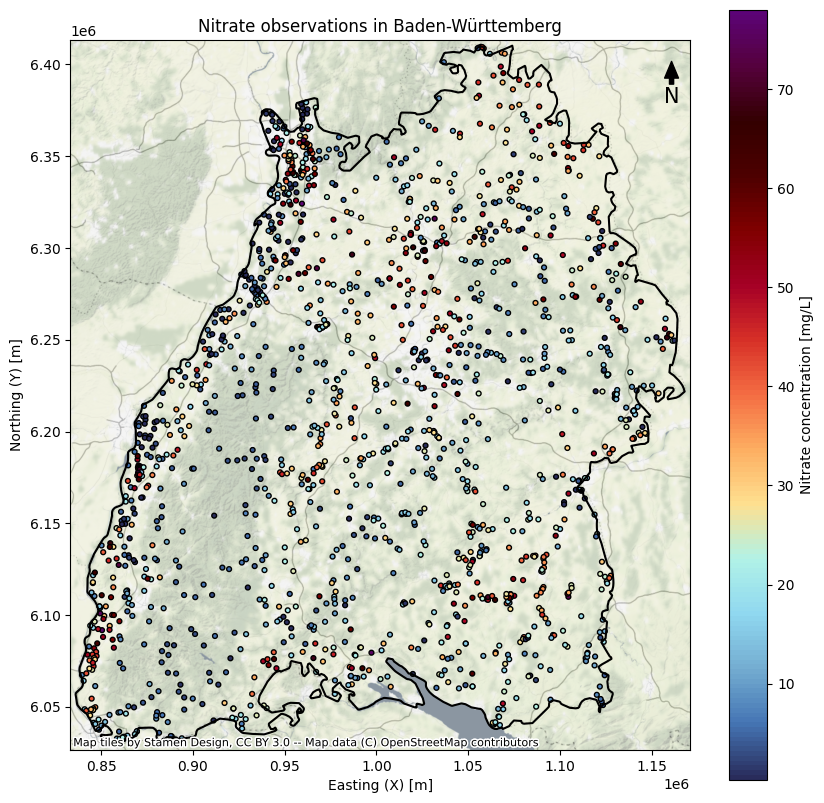

You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.


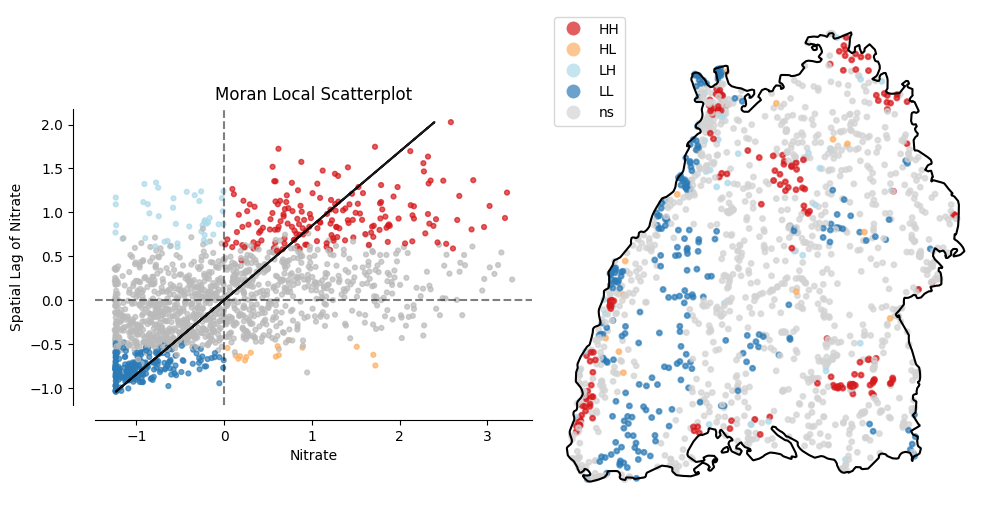

In [4]:
# Read data
df, gdf = read_data("point")

# Plot target concentration
plot_target_concentration(gdf, ms=12)

# Perform Moran analysis
plot_moran_analysis(gdf, p=0.05, ms=12)

## Create Spatial Information Features


In [5]:
# Start the timer
start_time = time.time()

# Preprocess the data
data = preprocess(df, variables, parameters)

# Generate the variable string
variable_str = generate_variable_string(variables, parameters)

EDF


## Encoding & Scaling

In [6]:
# Identify categorical variables (marked with asterisk in column name)
categorical_variables = [col for col in data.columns if '*' in col]

# Convert identified categorical variables to object type
data[categorical_variables] = data[categorical_variables].astype('object')

# Fit Leave-One-Out Encoder on categorical variables
encoder = LeaveOneOutEncoder().fit(data[categorical_variables], data['target'])

# Apply encoder transformation and concatenate with non-categorical columns
data_enc = pd.concat([data.drop(columns=categorical_variables), encoder.transform(data[categorical_variables])], axis=1)\
               .loc[:, data.columns]\
               .reset_index(drop=True)

# Extract the target variable and the input features
Y = data_enc['target'].values
X = data_enc.drop(columns=['target'])

# Fit StandardScaler on the input features
scaler = StandardScaler().fit(X)

# Scale the input features using the fitted scaler
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)


### CV and Model

In [7]:
# Set the number of splits for cross-validation
n_splits = 10

# Set CV_LOO to True for Leave-One-Out cross-validation, or False for K-Fold cross-validation
CV_LOO = False

# Create a RandomForestRegressor model with 100 estimators
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Define the cross-validation strategy based on CV_LOO
if CV_LOO:
    # Use Leave-One-Out cross-validation
    cv = LeaveOneOut()
else:
    # Use K-Fold cross-validation with n_splits
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)


In [8]:
# Define the scoring metrics and perform cross-validation
mae = -cross_val_score(model, X_scaled, Y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
mse = -cross_val_score(model, X_scaled, Y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)

# Use cross_val_predict to obtain cross-validated predictions
cv_pred = cross_val_predict(model, X_scaled, Y, cv=cv)

# Calculate additional evaluation metrics 
RMSE = np.sqrt(np.mean(mse))
r2 = r2_score(Y, cv_pred)
bias = np.mean(Y - cv_pred)


In [9]:
# Leave-One-Out CV Results
if CV_LOO:
    # Create a dictionary with the results data
    results_data = {
        "Measured": Y,
        "Predicted": cv_pred,
        "Resid": Y - cv_pred,
        "MAE": mae,
        'geometry': gdf.geometry.tolist()
    }
    
    # Create a DataFrame with the results data
    results_df = pd.DataFrame(results_data)

    # Compute Moran's I and add it as a new column
    moran, moran_global = plot_moran_residual_analysis(results_df, CV_LOO, p=0.05, ms=15)
    results_df['Moran'] = moran
    moran_I = moran_global.I
    moran_p_sim = moran_global.p_sim

    # Rearrange columns in the results DataFrame
    results_df = results_df[['Measured', 'Predicted', 'Resid', 'Moran', 'geometry']]

    # Calculate the elapsed time
    end_time = time.time()

    # Create a dictionary with the summarized results data
    results_data1 = {
        "MAE": np.mean(mae),
        "RMSE": RMSE,
        "R2": r2,
        "Bias": bias,
        "MoransI": moran_I,
        "MoransP": moran_p_sim,
        "Calc_time": end_time - start_time,
        "Name": variable_str
    }


    print("MAE: ", round(np.mean(mae), 2), ", RMSE: ", round(RMSE, 2), "R2: ", round(r2, 2))


In [10]:
# Leave-One-Out CV Results
if CV_LOO and save_results:
    file_path = f"./results.csv"
    fieldnames = ["MAE", "RMSE", "R2", "Bias", "MoransI", "MoransP", "Calc_time", "Name"]
    data_to_append = [results_data1]

    # Check if the file already exists
    try:
        with open(file_path, "r") as file:
            reader = csv.reader(file, delimiter=';')
            existing_names = set(row[-1] for row in reader)
    except FileNotFoundError:
        existing_names = set()

    # Append the data to the file if the name doesn't already exist
    with open(file_path, "a", newline="") as file:
        writer = csv.writer(file, delimiter=';')

        # Write the header if the file is empty
        if file.tell() == 0:
            writer.writerow(fieldnames)

        for data in data_to_append:
            if data["Name"] not in existing_names:
                writer.writerow([data[key] for key in fieldnames])
            else:
                print("duplicate")
                
# Non-Leave-One-Out CV Results
else:
    results_data1 = {
        "MAE": np.mean(mae),
        "RMSE": RMSE,
        "R2": r2,
        "Bias": bias,
        "Name": variable_str
    }

    print("MAE: ", round(np.mean(mae), 2), ", RMSE: ", round(RMSE, 2), "R2: ", round(r2, 2))
    
# Save Results (Non-Leave-One-Out CV)
if not CV_LOO and save_results:
    # Specify the file path and field names for the CSV file
    file_path = f"./cvresults_{n_splits}fold.csv"
    fieldnames = ["MAE", "RMSE", "R2", "Bias", "Name"]
    
    # Create a list with the results data to append
    data_to_append = [results_data1]

    # Check if the file already exists
    try:
        with open(file_path, "r") as file:
            reader = csv.reader(file, delimiter=';')
            existing_names = set(row[-1] for row in reader)
    except FileNotFoundError:
        existing_names = set()

    # Append the data to the file if the name doesn't already exist
    with open(file_path, "a", newline="") as file:
        writer = csv.writer(file, delimiter=';')

        # Write the header if the file is empty
        if file.tell() == 0:
            writer.writerow(fieldnames)

        for data in data_to_append:
            if data["Name"] not in existing_names:
                writer.writerow([data[key] for key in fieldnames])
            else:
                print("Duplicate")


MAE:  9.74 , RMSE:  13.15 R2:  0.41


 ## SHAP Values

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


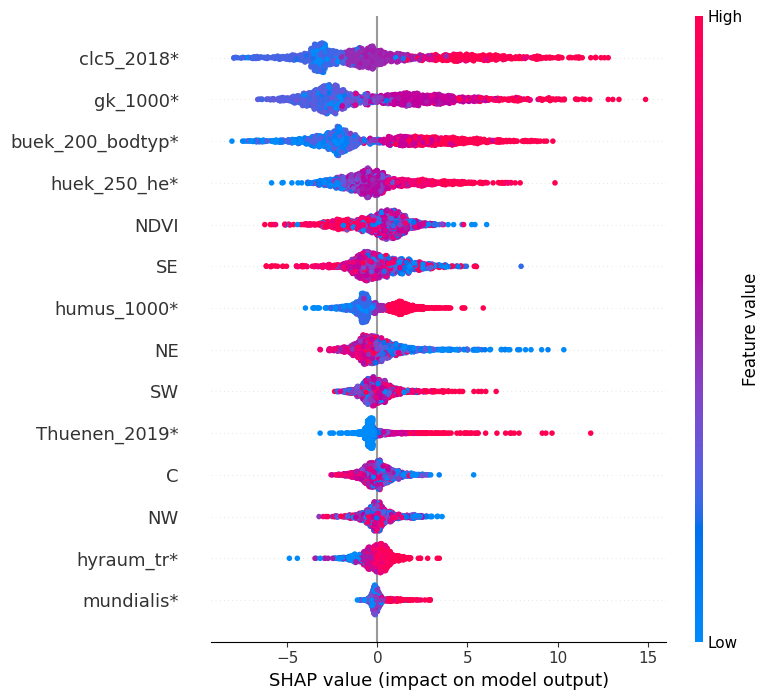

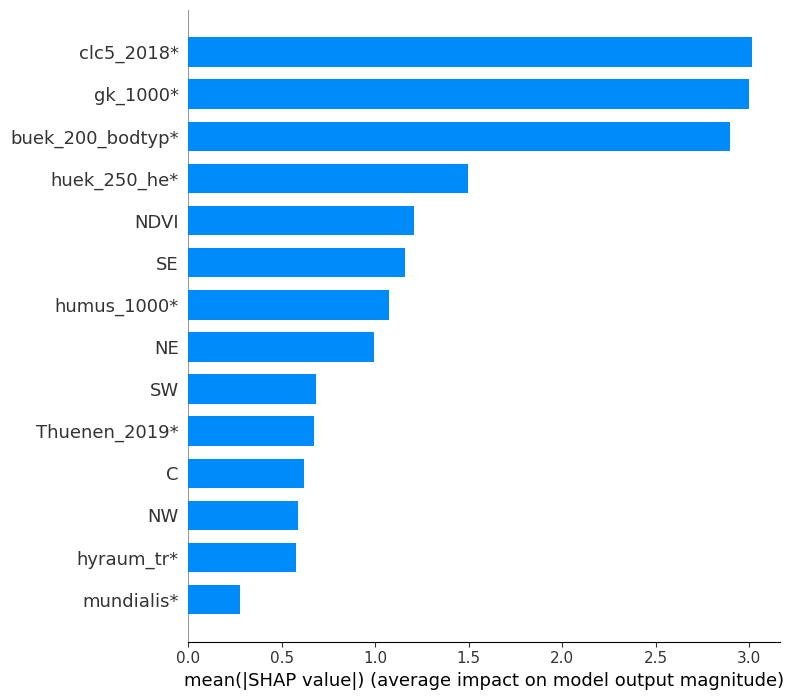

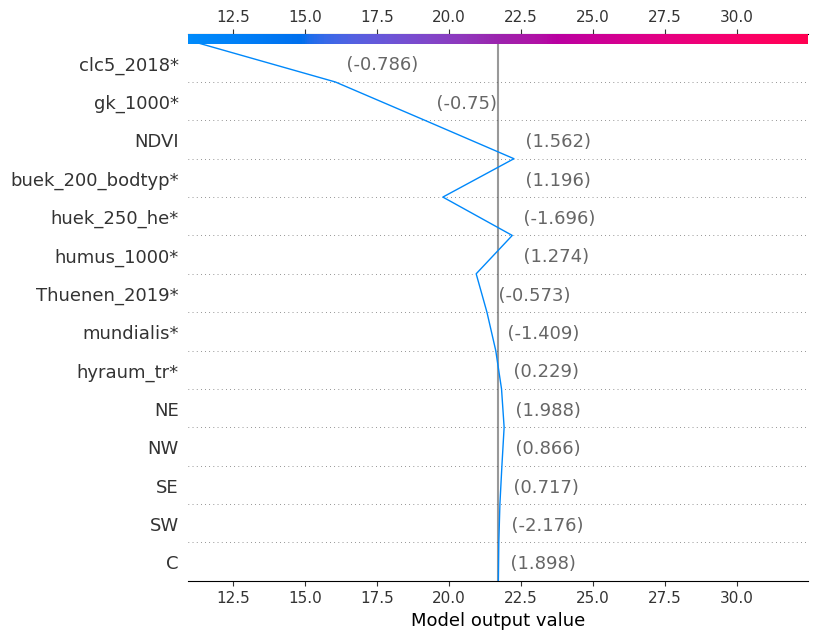

In [11]:
# Fit the model to the scaled input features and target variable
model.fit(X_scaled,Y)
# Create a TreeExplainer object with the trained model
explainer = shap.TreeExplainer(model)
# Calculate SHAP values for the input features using the TreeExplainer
shap_values = shap.TreeExplainer(model).shap_values(X_scaled, check_additivity=True)
# Generate SHAP plots
generate_shap_plots(shap_values, X_scaled, variable_str)


## Regionalization

In [12]:
# Read data from the "grid" source
df1, gdf1 = read_data("grid")
# Preprocess the data
data1 = preprocess(df1, variables, parameters,True)

EDF


In [13]:
# Target Encoding
data1_enc = data1.copy()

# Perform target encoding for each categorical variable
for k in categorical_variables:
    # Map each category to the mean target value for that category
    data1_enc[k] = data1[k].map(data.groupby(k)['target'].mean())

# Drop rows with missing values
data1_enc.dropna(inplace=True)   


In [14]:
# Prepare and scale input data
X_pred = data1_enc.copy()

# Scale the input data using the fitted scaler
X_pred_scaled = scaler.transform(X_pred)

# Create a DataFrame with the scaled data
X_pred_scaled = pd.DataFrame(X_pred_scaled)

# Set the column names and index of the scaled data to match X_pred
X_pred_scaled.columns = X_pred.columns
X_pred_scaled.index = X_pred.index


In [15]:
# Create a RandomForestRegressor model
model = RandomForestRegressor(verbose=0, n_jobs=20)

# Fit the model to the scaled input features (X_scaled) and target variable (Y)
model.fit(X_scaled, Y)

# Make predictions on the scaled input data (X_pred_scaled)
predicted = pd.DataFrame(model.predict(X_pred_scaled), columns=['Nitrat'])

# Set the index of the predictions DataFrame to match the index of X_pred
predicted.index = X_pred.index

# Merge the predictions with the data1_enc DataFrame based on the index
predicted = data1_enc.merge(predicted, left_index=True, right_index=True, how='right')

# Merge the predictions DataFrame with the geometry column of the gdf1 GeoDataFrame based on the index
predicted = predicted.loc[:, ['Nitrat']].merge(gdf1.geometry, left_index=True, right_index=True, how='left')

# Create a GeoDataFrame using the predicted DataFrame, specifying the geometry column and CRS
predicted = gpd.GeoDataFrame(predicted, geometry='geometry', crs='EPSG:32632')

# Print a message indicating that the regionalization process has finished
print('Finished Regionalization....')



Finished Regionalization....


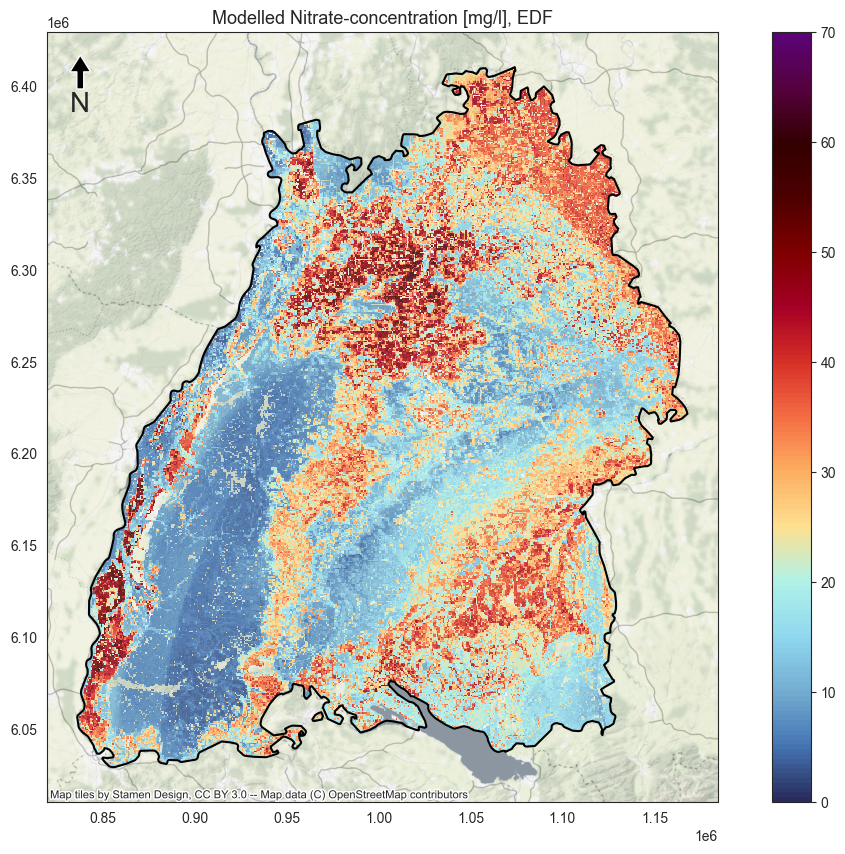

In [16]:
# Plot the spatial prediction
regio_plot(predicted, variable_str)